# Compile the main simulator code using cython 

In [1]:
!python ../setup.py build_ext --inplace

running build_ext
copying build/lib.macosx-10.9-x86_64-cpython-38/agent_timestep_plasticity.cpython-38-darwin.so -> 
running build_ext
copying build/lib.macosx-10.9-x86_64-cpython-38/agent_timestep_stop_signal.cpython-38-darwin.so -> 
/Users/cristina/Desktop/CBGTpy_git/CBGTPy/notebooks/agent_timestep_stop_signal.cpython-38-darwin.so
/Users/cristina/Desktop/CBGTpy_git/CBGTPy/notebooks/agent_timestep_plasticity.cpython-38-darwin.so


# Import all the relevant files 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import pathos.multiprocessing

In [3]:
import sys
sys.path.append('../')

#Importing scripts:

#Import relevant frames:
import common.cbgt as cbgt
import common.pipeline_creation as pl_creat

#Import plotting functions:
import common.plotting_functions as plt_func
import common.plotting_helper_functions as plt_help
import common.postprocessing_helpers as post_help

importlib.reload(plt_help)
importlib.reload(plt_func)
importlib.reload(post_help)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload 

import warnings
warnings.simplefilter('ignore', category=FutureWarning)

# Choose the experiment and create the main pipeline

Choose the experiment to run, and define the number of choices, the number of simulations/thread to run and number of cores:

In [4]:
#Choose the experiment:
experiment_choice = 'stop-signal'

if experiment_choice == 'stop-signal':
    import stopsignal.paramfile_stopsignal as paramfile
elif experiment_choice == 'n-choice':
    import nchoice.paramfile_nchoice as paramfile

number_of_choices = 2

#Choose which multiprocessing library to use:
use_library = "ray" # "none" or "pathos" or "ray"


# how many simulations do you want to run? each simulation is executed as a separate thread.
num_sims = 1
num_cores = 7


#Call choose_pipeline with the pipeline object:
pl_creat.choose_pipeline(experiment_choice)
#Create the main pipeline:
pl = pl_creat.create_main_pipeline(runloop=True)

#Set a seed:
seed = np.random.randint(0,99999999,1)[0]
print(seed)

in choose pipeline
in reward pipeline
75434668


Define data and figures directories:

In [5]:
data_dir = "../Data/"
figure_dir = "../Figures/"

# Modify cellular parameters as desired. 
### The paramfile has all the parameter dictionaries that can be modified. They are listed as below:
- celldefaults (neuronal parameters)
- d1defaults (dSPN parameters)
- d2defaults (iSPN parameters)
- dpmndefaults (dopamine related parameters)
- basestim (background input for the nuclei)
- popspecific (population specific parameters)
- receptordefaults (GABA, AMPA receptor parameters)
### The details of each of these dictionaries can be checked by simply typing paramfile.<parameter name> as also shown in the block below

In [6]:
# list out the available parameter dictionaries:
dir(paramfile)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'basestim',
 'celldefaults',
 'd1defaults',
 'd2defaults',
 'dpmndefaults',
 'np',
 'pd',
 'popspecific',
 'receptordefaults']

In [7]:
# view (or edit) one of the parameter dictionaries:
paramfile.celldefaults

{'N': 75,
 'C': 0.5,
 'Taum': 20,
 'RestPot': -70,
 'ResetPot': -55,
 'Threshold': -50,
 'RestPot_ca': -85,
 'Alpha_ca': 0.5,
 'Tau_ca': 80,
 'Eff_ca': 0.0,
 'tauhm': 20,
 'tauhp': 100,
 'V_h': -60,
 'V_T': 120,
 'g_T': 0,
 'g_adr_max': 0,
 'Vadr_h': -100,
 'Vadr_s': 10,
 'ADRRevPot': -90,
 'g_k_max': 0,
 'Vk_h': -34,
 'Vk_s': 6.5,
 'tau_k_max': 8,
 'n_k': 0,
 'h': 1}

### To change a parameter, simply assign the desired value to the parameter
### eg. paramfile.celldefaults['C'] = 0.5

In [8]:
# paramfile.celldefaults['C'] = 0.5

# Running the pipeline

### Define configuration parameter

In [9]:
configuration = {
    'experimentchoice': experiment_choice,
    'inter_trial_interval': None,
    'thalamic_threshold': 30.,
    'movement_time': ['mean', 250], #default sampled from N(250,1.5), ["constant",250], ["mean",250]
    'choice_timeout': 300,
    
    'params': paramfile.celldefaults,  #neuron parameters
    'pops': paramfile.popspecific,    #population parameters
    'receps' : paramfile.receptordefaults, #receptor parameters
    'base' : paramfile.basestim,   #baseline stimulation parameters
    'dpmns' : paramfile.dpmndefaults,  #dopamine related parameters
    'd1' : paramfile.d1defaults,     #dSPNs population related parameters
    'd2' : paramfile.d2defaults,     #iSPNs population related parameters
    'channels' : pd.DataFrame([['left'], ['right']], columns=['action']), #action channels related parameters
    'number_of_choices': number_of_choices,
    'newpathways' : None,     #connectivity parameters
    'Q_support_params': None, #initialization of Q-values update
    'Q_df_set': pd.DataFrame([[0.5, 0.5]],columns=["left", "right"]), #initialized Q-values df  
    'n_trials': 1,            #number of trials
    'volatility': [None,"exact"], #frequency of changepoints
    'conflict': (1.0, 0),         #probability of the preferred choice
    'reward_mu': 1,               #mean for the magnitude of the reward
    'reward_std': 0.1,            #std for the magnitude of the reward
    'maxstim': 0.8,               #amplitude of the cortical input over base line
    'sustainedfraction': 0.75,
    
    #Stop signal
    'stop_signal_present': [True,True],
    'stop_signal_probability': [1., 1.],  #probability of trials that will get the stop-signal / list of trial numbers
    'stop_signal_amplitude': [0.6, 0.6],  #amplitude of the stop signal over base line
    'stop_signal_onset': [60.,60.],       #in ms
    'stop_signal_duration' : ["phase 0",165.], 
    'stop_signal_channel': ["all","left"], #"all" (all channels are given the stop signal) 
                                            #"any" (channel given the stop signal is chosen randomly)
                                            # [list of channels] == subset of channels given the stop signal
    'stop_signal_population':["STN","GPeA"],
    
    'record_variables':["stop_input"],
    
    
    #Opto signal
    'opt_signal_present': [False],
    'opt_signal_probability': [1.], # probability of trials that will get the optogenetic signal / list of trial numbers
    'opt_signal_amplitude': [.7],   #amplitude of the stop signal over base line
    'opt_signal_onset': [30.],      #in ms
    'opt_signal_duration': [150.],
    'opt_signal_channel': ["all"],  # "all" (all channels are given the stop signal) 
                                    #"any" (channel given the stop signal is chosen randomly)
                                    # [list of channels] == subset of channels given the stop signal
    
    'opt_signal_population':["iSPN"],
}

### Run the simulation

ExecutionManager class can take for 'use': 

- 'none', that corresponds to the singlethreaded mode;
- 'pathos', that corresponds to python's multiprocessing mode;
- 'ray', that corresponds to a multiprocessing library for python that operates on a client-server mode.

The default value is None (singlethreaded mode).

In [10]:
results = cbgt.ExecutionManager(cores=num_cores,use=use_library).run([pl]*num_sims,[configuration]*num_sims)

2023-12-13 17:06:55,621	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-12-13 17:06:55,676	INFO worker.py:1489 -- Connecting to existing Ray cluster at address: 127.0.0.1:6379...
2023-12-13 17:06:55,687	INFO worker.py:1673 -- Connected to Ray cluster.
2023-12-13 17:06:55,694	INFO packaging.py:530 -- Creating a file package for local directory '/Users/cristina/Desktop/CBGTpy_git/CBGTPy/common'.
2023-12-13 17:06:55,699	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_27a4ed2d64f2b1b6.zip' (0.23MiB) to Ray cluster...
2023-12-13 17:06:55,702	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_27a4ed2d64f2b1b6.zip'.
2023-12-13 17:06:55,706	INFO packaging.py:530 -- Creating a file package for local directory '/Users/cristina/Desktop/CBGTpy_git/CBGTPy/nchoice'.
2023-12-13 17:06:55,708	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_93cd2580de3

SpawnThreadManagers <common.backend.Pipeline object at 0x7f8290d8ba90>
(workerFunc pid=23152) in choose pipeline
(workerFunc pid=23152) conflict (1.0, 0)
(workerFunc pid=23152) conflict (1.0, 0)
(workerFunc pid=23152) sum 1.0
(workerFunc pid=23152) n_prob_trials [1, 0]
(workerFunc pid=23152) calc_rew        left  right
(workerFunc pid=23152) 0  1.097874    0.0
(workerFunc pid=23152) reward_list        left  right
(workerFunc pid=23152) 0  1.097874    0.0
SpawnThreadManagers <common.backend.Pipeline object at 0x7f8290d9a1c0>
(workerFunc pid=23152) scaling_conn 1.0
(workerFunc pid=23152) scaling_wts 1
(workerFunc pid=23152) begin GenOptSchedule
(workerFunc pid=23152) <class 'list'>
(workerFunc pid=23152) [0]
(workerFunc pid=23152) pop i
(workerFunc pid=23152) True
(workerFunc pid=23152) pop S
(workerFunc pid=23152) True
(workerFunc pid=23152) pop P
(workerFunc pid=23152) True
(workerFunc pid=23152) pop N
(workerFunc pid=23152) True
(workerFunc pid=23152) opt_amplitude_dfs [   left  right

# Results

List all the agent variables accessible: 

In [11]:
results[0].keys()

dict_keys(['experimentchoice', 'inter_trial_interval', 'thalamic_threshold', 'movement_time', 'choice_timeout', 'params', 'pops', 'receps', 'base', 'dpmns', 'd1', 'd2', 'channels', 'number_of_choices', 'newpathways', 'Q_support_params', 'Q_df_set', 'n_trials', 'volatility', 'conflict', 'reward_mu', 'reward_std', 'maxstim', 'sustainedfraction', 'stop_signal_present', 'stop_signal_probability', 'stop_signal_amplitude', 'stop_signal_onset', 'stop_signal_duration', 'stop_signal_channel', 'stop_signal_population', 'record_variables', 'opt_signal_present', 'opt_signal_probability', 'opt_signal_amplitude', 'opt_signal_onset', 'opt_signal_duration', 'opt_signal_channel', 'opt_signal_population', 'par', 'popconstruct', 'interface', 'gen_stop', 'actionchannels', 'trial_wise_movement_times', 'volatile_pattern', 'cp_idx', 'cp_indicator', 'noisy_pattern', 't_epochs', 'block', 'trial_num', 'chosen_action', 'celldefaults', 'popspecific', 'receptordefaults', 'basestim', 'dpmndefaults', 'd1defaults', '

In [12]:
results[0]['stop_list_trials_list']

[array([0]), array([0])]

In [13]:
results[0]['meaneff_GABA']

,GPi,GPi,STN,STN,GPeP,GPeP,GPeA,GPeA,dSPN,dSPN,iSPN,iSPN,Cx,Cx,Th,Th,FSI,CxI
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`,0.0`
GPi,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.3315`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
STN,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
GPeP,0.058`,0.0`,0.37`,0.0`,0.45`,0.45`,0.3`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.1`,0.0`
GPeP,0.0`,0.058`,0.0`,0.37`,0.45`,0.45`,0.0`,0.3`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.1`,0.0`
GPeA,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.15`,0.15`,0.32`,0.0`,0.12`,0.0`,0.0`,0.0`,0.0`,0.0`,0.01`,0.0`
GPeA,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.15`,0.15`,0.0`,0.32`,0.0`,0.12`,0.0`,0.0`,0.0`,0.0`,0.01`,0.0`
dSPN,1.8`,0.0`,0.0`,0.0`,0.0`,0.0`,0.054`,0.0`,0.28`,0.0`,0.28`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`
dSPN,0.0`,1.8`,0.0`,0.0`,0.0`,0.0`,0.0`,0.054`,0.0`,0.28`,0.0`,0.28`,0.0`,0.0`,0.0`,0.0`,0.0`,0.0`


In [14]:
results[0]['stop_signal_amplitude']

[0.6, 0.6]

In [15]:
experiment_choice

'stop-signal'

Extract all the relevant dataframes:

In [16]:
firing_rates, rt_dist = plt_help.extract_relevant_frames(results,seed,experiment_choice)

In [17]:
results[0]['popfreqs']

,GPi_left,GPi_right,STN_left,STN_right,GPeP_left,GPeP_right,GPeA_left,GPeA_right,dSPN_left,dSPN_right,iSPN_left,iSPN_right,Cx_left,Cx_right,Th_left,Th_right,FSI_common,CxI_common,Time (ms)
0,78.666667,77.333333,24.577778,25.911111,55.535714,51.875000,7.807018,5.526316,2.000000,3.777778,3.555556,4.222222,0.000000,0.000000,4.666667,6.000000,7.777778,0.806452,0
1,76.888889,78.000000,24.555556,26.066667,55.505952,51.755952,7.894737,5.526316,2.222222,3.777778,4.000000,4.444444,0.000000,0.000000,4.888889,6.000000,8.000000,0.806452,1
2,76.666667,79.111111,24.577778,26.377778,55.119048,51.934524,7.982456,5.526316,2.000000,4.222222,3.777778,4.444444,0.000000,0.000000,5.333333,5.777778,8.000000,0.806452,2
3,76.222222,79.111111,24.844444,26.600000,55.178571,51.875000,7.894737,5.701754,1.777778,4.222222,4.000000,4.444444,0.000000,0.000000,5.333333,5.555556,8.222222,0.806452,3
4,76.444444,79.111111,25.155556,27.377778,55.208333,52.202381,7.982456,5.789474,1.777778,3.777778,4.000000,4.222222,0.000000,0.000000,5.333333,5.333333,7.777778,0.806452,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,76.000000,76.444444,25.711111,24.311111,50.863095,56.160714,11.315789,9.298246,3.333333,3.777778,5.333333,4.666667,3.022876,2.614379,7.555556,5.555556,8.222222,2.508961,1152
1153,77.555556,75.333333,25.644444,24.266667,50.535714,55.982143,11.578947,9.385965,3.111111,4.000000,5.111111,4.666667,3.022876,2.696078,7.333333,5.555556,8.222222,2.419355,1153
1154,77.555556,75.111111,25.666667,24.311111,50.982143,55.892857,11.578947,9.298246,2.888889,4.000000,5.111111,4.666667,3.022876,2.859477,7.333333,5.777778,8.444444,2.419355,1154
1155,77.555556,73.555556,25.955556,24.222222,51.220238,56.071429,11.754386,8.947368,2.888889,4.000000,5.111111,4.666667,3.022876,2.696078,6.888889,6.000000,7.555556,2.419355,1155


In [18]:
firing_rates[0]

,Time (ms),variable,firing_rate,nuclei,channel,seed
0,0,GPi_left,78.666667,GPi,left,75434668_0
1,1,GPi_left,76.888889,GPi,left,75434668_0
2,2,GPi_left,76.666667,GPi,left,75434668_0
3,3,GPi_left,76.222222,GPi,left,75434668_0
4,4,GPi_left,76.444444,GPi,left,75434668_0
...,...,...,...,...,...,...
20821,1152,CxI_common,2.508961,CxI,common,75434668_0
20822,1153,CxI_common,2.419355,CxI,common,75434668_0
20823,1154,CxI_common,2.419355,CxI,common,75434668_0
20824,1155,CxI_common,2.419355,CxI,common,75434668_0


In [19]:
recorded_variables = post_help.extract_recording_variables(results,results[0]['record_variables'],seed)

['left' 'right']


In [20]:
recorded_variables['stop_input']#.melt(id_vars='Time(ms)')

,index,value,nuclei,Time(ms),seed
0,0,5.05,STN-left,0,75434668_0
1,1,5.05,STN-left,1,75434668_0
2,2,5.05,STN-left,2,75434668_0
3,3,5.05,STN-left,3,75434668_0
4,4,5.05,STN-left,4,75434668_0
...,...,...,...,...,...
4619,1151,2.50,GPeA-right,1151,75434668_0
4620,1152,2.50,GPeA-right,1152,75434668_0
4621,1153,2.50,GPeA-right,1153,75434668_0
4622,1154,2.50,GPeA-right,1154,75434668_0


Plot the recorded variable extracted. Figure is saved in the figure_dir previously specified:

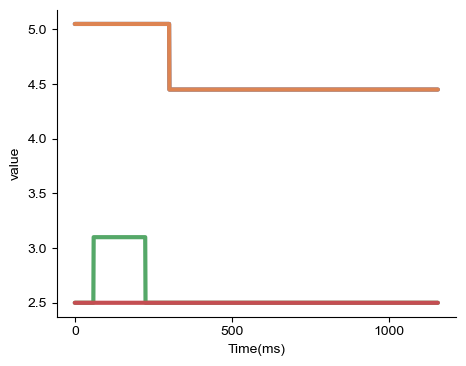

In [21]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
sns.set(style="white", font_scale=1.5)
sns.lineplot(x="Time(ms)",y="value",data=recorded_variables['stop_input'],hue='nuclei',lw=3.0,ax=ax)
ax.legend_.remove()
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.tight_layout()
#fig.savefig(figure_dir+'stop_input.png')

Extract the data tables from the agent:

In [22]:
datatables = cbgt.collateVariable(results,'datatables')
datatables[0]

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward
0,stop,0,301,301,555,555,left,0


Save the selected variables of results in the data_dir previously specified:

In [23]:
postfix=""
cbgt.saveResults(results,data_dir+'network_data_'+str(seed)+'.pickle',['popfreqs','popdata','datatables'])

In [24]:
firing_rates[0].to_csv(data_dir+"firing_rates_"+postfix+".csv")
rt_dist.to_csv(data_dir+"rt_dist_"+postfix+".csv")

Plot the firing rates extracted (figure handles are returned in fig_handles).
Figure is saved in the figure_dir previously specified:

/opt/anaconda3/envs/cbgtpy_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


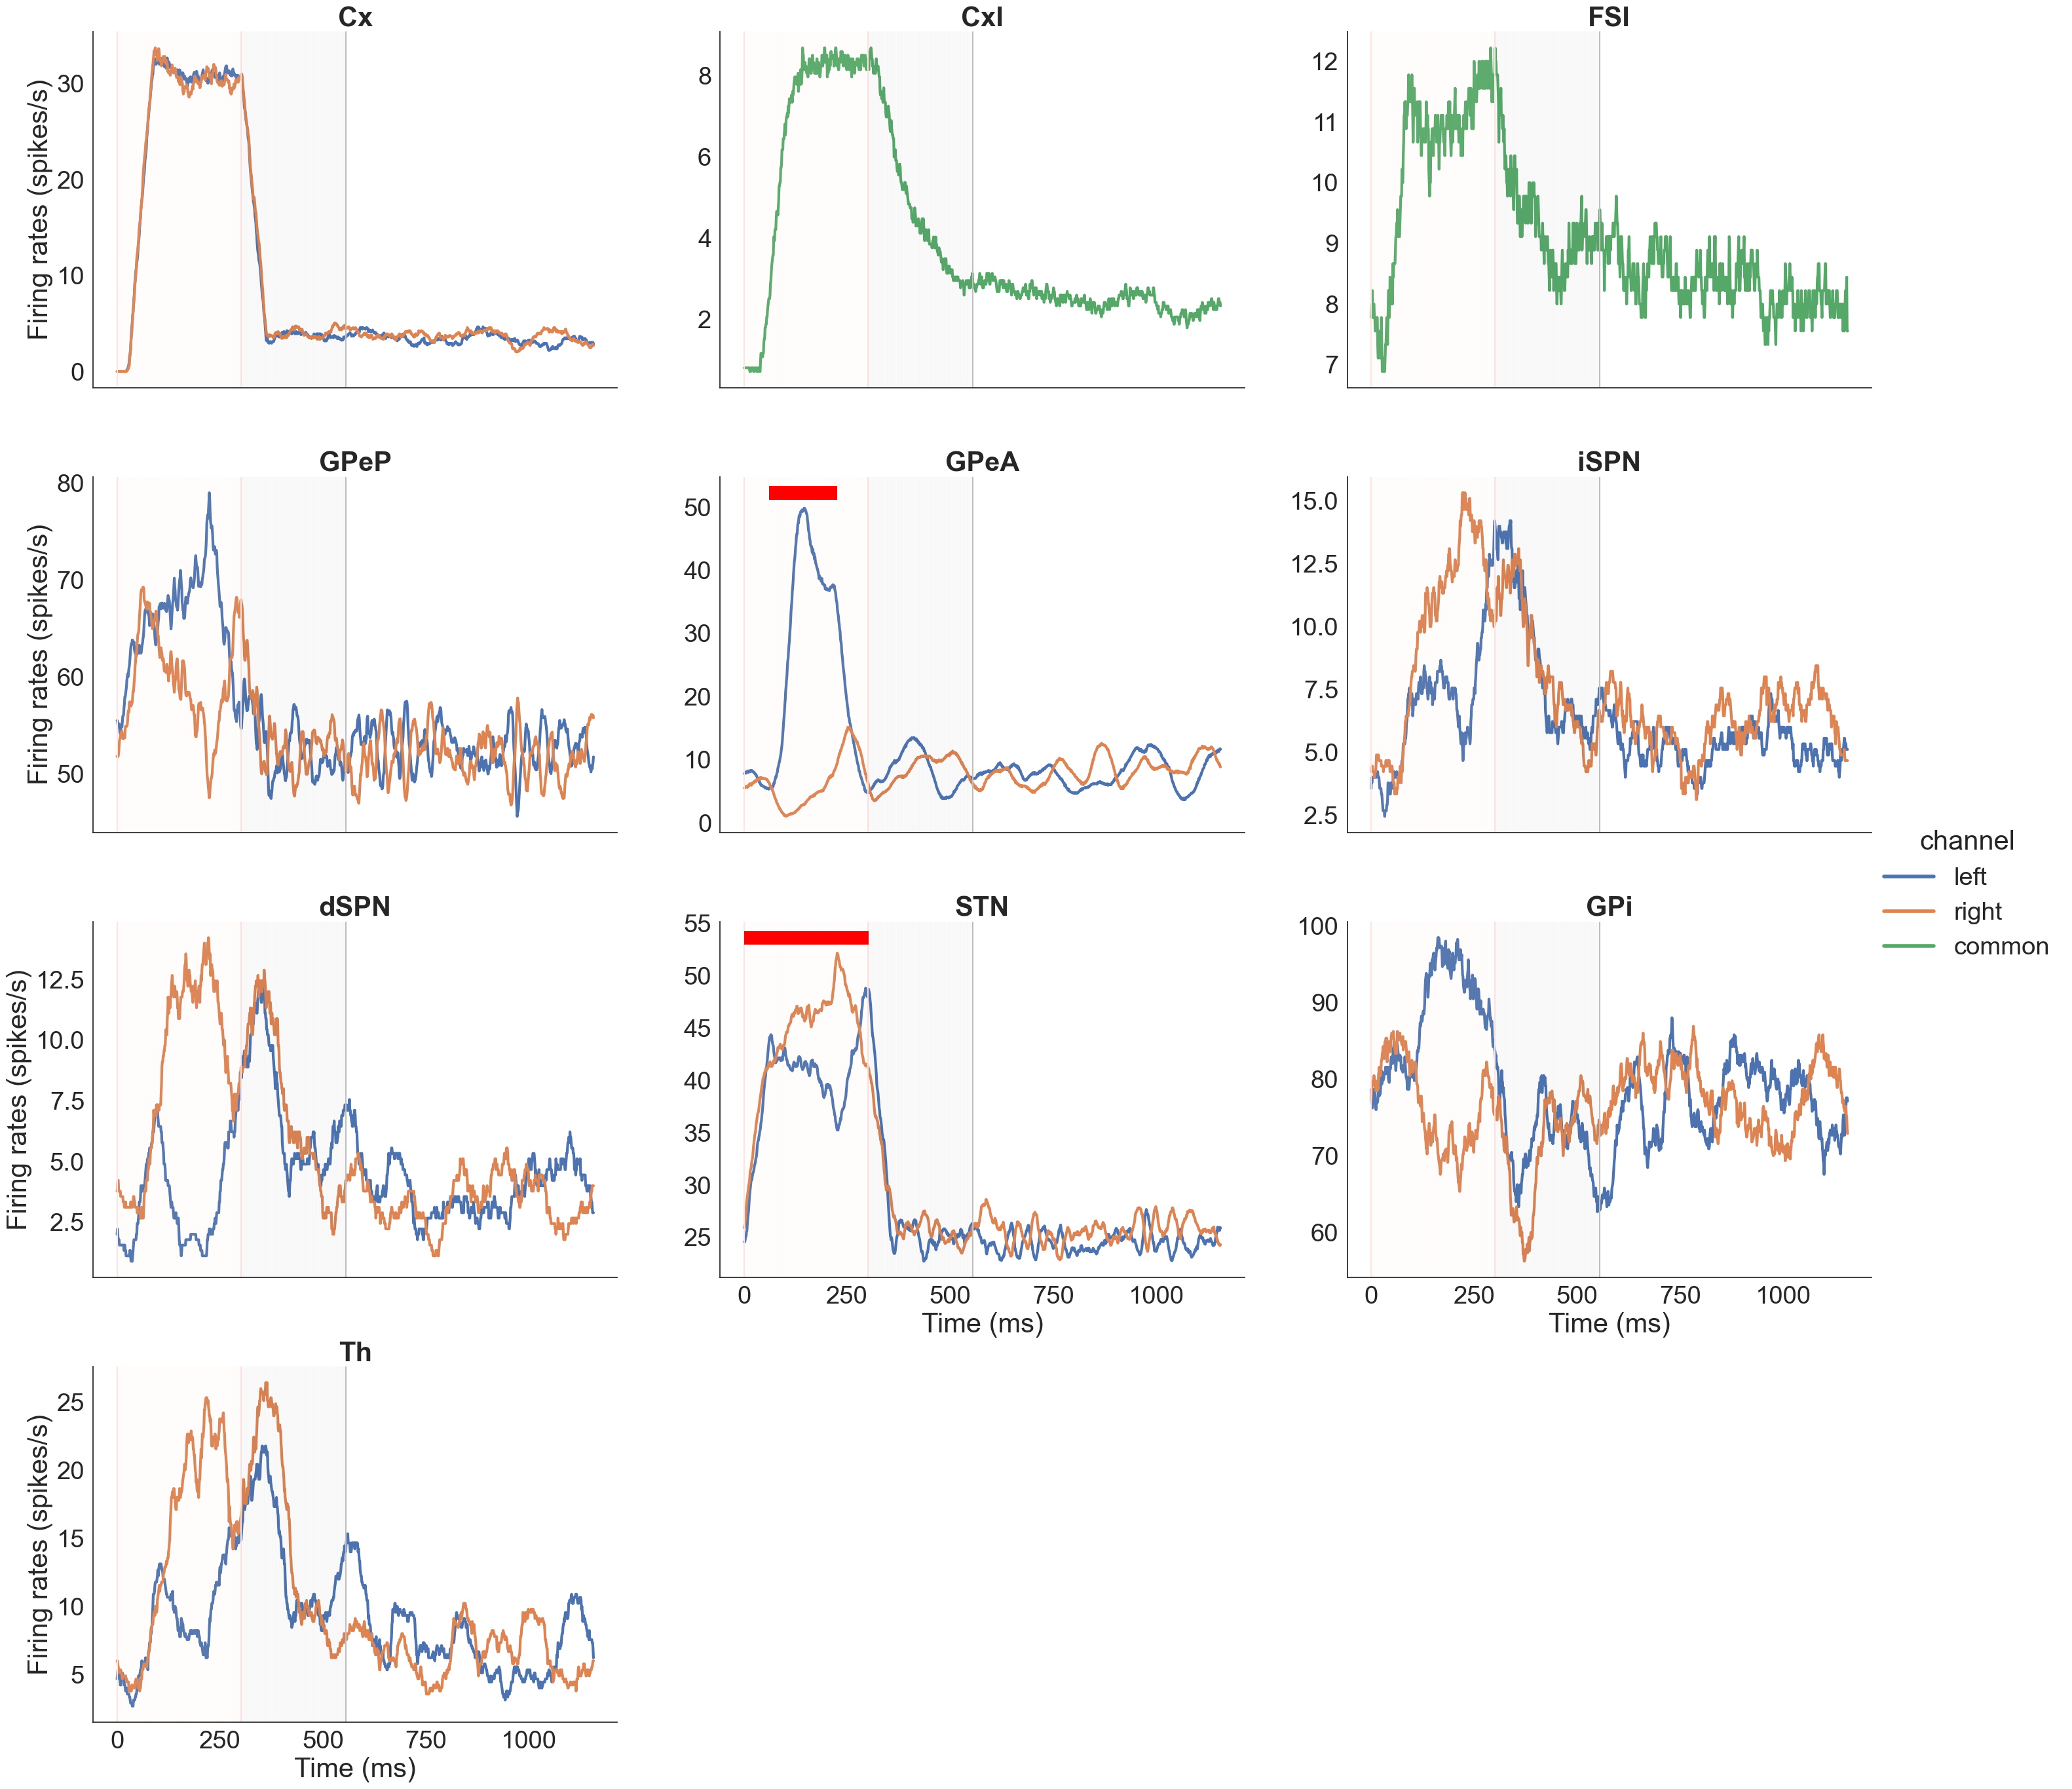

In [25]:
FR_fig_handles = plt_func.plot_fr(firing_rates,datatables,results,experiment_choice,True)
FR_fig_handles[0].savefig(figure_dir+"Example_FR_stopsignal.png",dpi=300)